# Анализ данных и обучение нейронной сети

В этой части работы будут загружены файлы с данными сгенерированных фитированных синтетических кривых малоуглового рассеяния, которые были размечены на основе фитирования, для обучения на них нейросети. Данные будут объединены в один общий датасет, визуализированы и подготовлены для обучения. Затем они будут разделены на тренировочную и валидационную выборки и поданы на вход нейронной сети. Файл, содержащий реальные данные со спектрометра малоуглового рассеяния ЮМО, будет использован в качестве тестовой выборки, на которой будет оценено качество модели.

## Содержание
1. Синтетические данные
  * Загрузка и обзор синтетических данных
  * Обработка и анализ данных
2. Тестовые реальные данные
  * Загрузка и обзор тестовых данных
  * Обработка и анализ тестовых данных
3. Сравнение синтетических и реальных данных
4. Обучение нейросети
5. Тестирование модели
6. Общий вывод




## Синтетические данные

### Загрузка и обзор синтетических данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import ast
import re
import joblib

Загрузим датасеты и создадим словарь с ними.

In [2]:
def download_dfs(file):

    pth1 = "/content/" + file
    if os.path.exists(pth1):
        df = pd.read_csv(pth1)
    else:
        return 'Ошибка'
    return df


datasets = {}
for i in range(20, 41):
    datasets[f'fitted_for_train_synthetic_vesicles_polydisperse_p_0_{i}'] = download_dfs(f'fitted_for_train_synthetic_vesicles_polydisperse_p_0_{i}.csv')


In [3]:
datasets['fitted_for_train_synthetic_vesicles_polydisperse_p_0_21'].head()

,q_angstrom,I,errors_I,errors_q,errors_I_rel,errors_q_rel,thickness,radius,polydispersity,filename,radius_fitted,thickness_fitted,scale,background,chi2
0,[0.00870964 0.00906512 0.00943512 0.00982022 0...,[3.10380438e+02 2.93517169e+02 2.92429358e+02 ...,[3.47726042e+01 3.21197685e+01 3.19481322e+01 ...,[0.00113099 0.00109679 0.00119234 0.00123656 0...,[11.20322031 10.94306291 10.92507686 10.159927...,[12.98551655 12.0990603 12.63727428 12.591993...,43.767427,399.682855,0.21,vesicle_0000.dat,447.668132,44.127259,0.588584,0.016870,2.974524
1,[0.00870964 0.00906512 0.00943512 0.00982022 0...,[3.16573573e+02 2.96489423e+02 3.02858901e+02 ...,[4.04006526e+01 3.54242882e+01 3.57792469e+01 ...,[0.00110744 0.00116823 0.001139 0.00120716 0...,[12.76185256 11.94790961 11.8138337 11.174852...,[12.71516437 12.88709802 12.07196289 12.292595...,35.584734,399.273640,0.21,vesicle_0001.dat,421.184223,35.078953,0.723549,0.015726,1.755021
2,[0.00870964 0.00906512 0.00943512 0.00982022 0...,[2.73016634e+02 3.53056089e+02 3.31454919e+02 ...,[3.47482893e+01 4.11325047e+01 4.03933289e+01 ...,[0.00112895 0.00113296 0.0011197 0.00122889 0...,[12.72753561 11.65041647 12.18667357 11.587769...,[12.96207797 12.49803725 11.86738744 12.513888...,48.816326,399.165164,0.21,vesicle_0002.dat,385.292141,48.570475,0.529849,0.018135,1.059381
3,[0.00870964 0.00906512 0.00943512 0.00982022 0...,[3.39918282e+02 3.64790134e+02 2.96887719e+02 ...,[4.12045403e+01 4.44322841e+01 3.48946348e+01 ...,[0.00103942 0.00110957 0.00112937 0.00120403 0...,[12.1218959 12.18023185 11.75347867 11.372023...,[11.93415195 12.23998918 11.96990399 12.260696...,42.449007,399.073770,0.21,vesicle_0003.dat,381.644612,41.937577,0.607556,0.021460,1.159965
4,[0.00870964 0.00906512 0.00943512 0.00982022 0...,[3.02971801e+02 3.14146371e+02 3.03960909e+02 ...,[3.54293568e+01 3.50036832e+01 3.31148733e+01 ...,[0.00110007 0.00110013 0.00117295 0.0012199 0...,[11.69394535 11.14247576 10.89445136 10.429601...,[12.63049285 12.13584921 12.43177163 12.422342...,46.225861,398.630664,0.21,vesicle_0004.dat,379.911551,45.782452,0.562827,0.024146,1.554009


Объединим все 21 датасет с синтетическими кривыми малоуглового рассеяния в один общий датасет.

In [4]:
df_concat = pd.concat([datasets[f'fitted_for_train_synthetic_vesicles_polydisperse_p_0_{i}'] for i in range(20, 41)],
                        ignore_index=True)

In [5]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   q_angstrom        21000 non-null  object 
 1   I                 21000 non-null  object 
 2   errors_I          21000 non-null  object 
 3   errors_q          21000 non-null  object 
 4   errors_I_rel      21000 non-null  object 
 5   errors_q_rel      21000 non-null  object 
 6   thickness         21000 non-null  float64
 7   radius            21000 non-null  float64
 8   polydispersity    21000 non-null  float64
 9   filename          21000 non-null  object 
 10  radius_fitted     21000 non-null  float64
 11  thickness_fitted  21000 non-null  float64
 12  scale             21000 non-null  float64
 13  background        21000 non-null  float64
 14  chi2              21000 non-null  float64
dtypes: float64(8), object(7)
memory usage: 2.4+ MB


In [6]:
display(df_concat.duplicated().sum())
display(df_concat.isna().sum().sum())

np.int64(0)

np.int64(0)

Таким образом, в общем датасете 21000 данных с синтетическими кривыми малоуглового рассеяния нейтронов и целевым признаком thickness_fitted. При загрузке и формировании датасеты проблемы в виде дубликатов и пропущенных значений не наблюдаются

### Обработка и анализ данных

In [7]:
df_concat.head()

,q_angstrom,I,errors_I,errors_q,errors_I_rel,errors_q_rel,thickness,radius,polydispersity,filename,radius_fitted,thickness_fitted,scale,background,chi2
0,[0.00870964 0.00906512 0.00943512 0.00982022 0...,[2.95440974e+02 3.38235120e+02 3.58586398e+02 ...,[3.52948954e+01 3.97464459e+01 3.59767550e+01 ...,[0.00109112 0.00113808 0.00114038 0.00118734 0...,[11.94651336 11.75112917 10.03293912 9.824550...,[12.52776624 12.5544417 12.08655719 12.090743...,49.869801,399.987108,0.2,vesicle_0000.dat,418.747109,49.187062,0.531946,0.026923,2.015209
1,[0.00870964 0.00906512 0.00943512 0.00982022 0...,[2.91212969e+02 2.77453380e+02 3.10281695e+02 ...,[4.69643387e+01 4.43713734e+01 4.35373941e+01 ...,[0.00106137 0.00114438 0.00120354 0.00118526 0...,[16.1271453 15.9923708 14.03157029 13.181006...,[12.18618926 12.62402118 12.75592619 12.069613...,40.340601,399.910489,0.2,vesicle_0001.dat,419.960512,39.875596,0.660623,0.022592,1.282382
2,[0.00870964 0.00906512 0.00943512 0.00982022 0...,[2.99533541e+02 3.09127055e+02 2.86647795e+02 ...,[3.57339549e+01 3.99073765e+01 3.31065881e+01 ...,[0.00106886 0.00109628 0.00121808 0.00116627 0...,[11.9298676 12.90970034 11.54957015 11.093189...,[12.2721741 12.09340402 12.91004695 11.876202...,40.679360,399.728271,0.2,vesicle_0002.dat,420.099032,39.912231,0.657804,0.005000,3.390163
3,[0.00870964 0.00906512 0.00943512 0.00982022 0...,[3.15507620e+02 3.12045591e+02 3.38627985e+02 ...,[4.12013899e+01 3.81043684e+01 3.77578461e+01 ...,[0.00107002 0.00117797 0.00115897 0.00122501 0...,[13.05876222 12.21115423 11.15024387 10.454424...,[12.2855276 12.99456769 12.28361346 12.474414...,41.308001,399.381731,0.2,vesicle_0003.dat,416.129838,41.499613,0.640041,0.029617,1.038466
4,[0.00870964 0.00906512 0.00943512 0.00982022 0...,[2.46127341e+02 2.90527575e+02 2.80732554e+02 ...,[2.96325318e+01 3.65359231e+01 3.35418757e+01 ...,[0.00105167 0.00112201 0.0012027 0.00122558 0...,[12.03951242 12.57571613 11.94798223 11.267773...,[12.0747869 12.37725813 12.74706727 12.480200...,47.937970,398.813139,0.2,vesicle_0004.dat,411.868015,47.713568,0.560823,0.020099,2.580986


Проведем обработку значений в ячейках I - преобразование строк в  массивы для столбца I.

In [8]:
def parse_array_string(array_str):

    # Удаляем пробелы, переносы строк и запятые
    cleaned = re.sub(r'\s+', ' ', str(array_str).strip())

    # Удаляем квадратные скобки и запятые
    cleaned = cleaned.replace('[', '').replace(']', '').replace(',', '')

    # Разделяем по пробелам и преобразуем в float
    values = [float(x) for x in cleaned.split() if x]
    return values

df_concat['I'] = df_concat['I'].apply(parse_array_string)

Преобразуем строки в массивы для столбца I.

In [9]:
# Проверим длину первого элемента I и первые 10 значений I первого элемента
first_element = df_concat['I'].iloc[0]
display(len(first_element))
display(first_element[:10])

df_concat['I'] = df_concat['I'].apply(lambda x: np.array(x) if isinstance(x, list) else x)
# df_concat = df_concat[df_concat['I'].apply(lambda x: np.all(x >= 0.001))]

display(df_concat.info())

100

[295.440974,
 338.23512,
 358.586398,
 372.226378,
 340.622977,
 293.180937,
 278.316716,
 248.98496,
 203.963382,
 183.799415]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   q_angstrom        21000 non-null  object 
 1   I                 21000 non-null  object 
 2   errors_I          21000 non-null  object 
 3   errors_q          21000 non-null  object 
 4   errors_I_rel      21000 non-null  object 
 5   errors_q_rel      21000 non-null  object 
 6   thickness         21000 non-null  float64
 7   radius            21000 non-null  float64
 8   polydispersity    21000 non-null  float64
 9   filename          21000 non-null  object 
 10  radius_fitted     21000 non-null  float64
 11  thickness_fitted  21000 non-null  float64
 12  scale             21000 non-null  float64
 13  background        21000 non-null  float64
 14  chi2              21000 non-null  float64
dtypes: float64(8), object(7)
memory usage: 2.4+ MB


None

In [10]:
df_concat.head()

,q_angstrom,I,errors_I,errors_q,errors_I_rel,errors_q_rel,thickness,radius,polydispersity,filename,radius_fitted,thickness_fitted,scale,background,chi2
0,[0.00870964 0.00906512 0.00943512 0.00982022 0...,"[295.440974, 338.23512, 358.586398, 372.226378...",[3.52948954e+01 3.97464459e+01 3.59767550e+01 ...,[0.00109112 0.00113808 0.00114038 0.00118734 0...,[11.94651336 11.75112917 10.03293912 9.824550...,[12.52776624 12.5544417 12.08655719 12.090743...,49.869801,399.987108,0.2,vesicle_0000.dat,418.747109,49.187062,0.531946,0.026923,2.015209
1,[0.00870964 0.00906512 0.00943512 0.00982022 0...,"[291.212969, 277.45338, 310.281695, 297.840119...",[4.69643387e+01 4.43713734e+01 4.35373941e+01 ...,[0.00106137 0.00114438 0.00120354 0.00118526 0...,[16.1271453 15.9923708 14.03157029 13.181006...,[12.18618926 12.62402118 12.75592619 12.069613...,40.340601,399.910489,0.2,vesicle_0001.dat,419.960512,39.875596,0.660623,0.022592,1.282382
2,[0.00870964 0.00906512 0.00943512 0.00982022 0...,"[299.533541, 309.127055, 286.647795, 329.50599...",[3.57339549e+01 3.99073765e+01 3.31065881e+01 ...,[0.00106886 0.00109628 0.00121808 0.00116627 0...,[11.9298676 12.90970034 11.54957015 11.093189...,[12.2721741 12.09340402 12.91004695 11.876202...,40.679360,399.728271,0.2,vesicle_0002.dat,420.099032,39.912231,0.657804,0.005000,3.390163
3,[0.00870964 0.00906512 0.00943512 0.00982022 0...,"[315.50762, 312.045591, 338.627985, 330.149223...",[4.12013899e+01 3.81043684e+01 3.77578461e+01 ...,[0.00107002 0.00117797 0.00115897 0.00122501 0...,[13.05876222 12.21115423 11.15024387 10.454424...,[12.2855276 12.99456769 12.28361346 12.474414...,41.308001,399.381731,0.2,vesicle_0003.dat,416.129838,41.499613,0.640041,0.029617,1.038466
4,[0.00870964 0.00906512 0.00943512 0.00982022 0...,"[246.127341, 290.527575, 280.732554, 360.64488...",[2.96325318e+01 3.65359231e+01 3.35418757e+01 ...,[0.00105167 0.00112201 0.0012027 0.00122558 0...,[12.03951242 12.57571613 11.94798223 11.267773...,[12.0747869 12.37725813 12.74706727 12.480200...,47.937970,398.813139,0.2,vesicle_0004.dat,411.868015,47.713568,0.560823,0.020099,2.580986


Удалим те кривые, для которых значение хи-квадрата после фитирования оказалось больше 4. Такие кривые имели довольно сильную зашумленность, что затрудняло их фитирование, либо структурные параметры были определены неверно (к этому особенно чувствительна область кривой при относительно малых q).

In [11]:
df_concat = df_concat[df_concat['chi2'] < 4]

df_concat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20258 entries, 0 to 20999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   q_angstrom        20258 non-null  object 
 1   I                 20258 non-null  object 
 2   errors_I          20258 non-null  object 
 3   errors_q          20258 non-null  object 
 4   errors_I_rel      20258 non-null  object 
 5   errors_q_rel      20258 non-null  object 
 6   thickness         20258 non-null  float64
 7   radius            20258 non-null  float64
 8   polydispersity    20258 non-null  float64
 9   filename          20258 non-null  object 
 10  radius_fitted     20258 non-null  float64
 11  thickness_fitted  20258 non-null  float64
 12  scale             20258 non-null  float64
 13  background        20258 non-null  float64
 14  chi2              20258 non-null  float64
dtypes: float64(8), object(7)
memory usage: 2.5+ MB


Было удалено 742 кривые малоуглового рассеяния. В итогом датасете осталось 20258 кривых.

Визуализируем распределение данных в столбцах, чтобы оценить качество фитирования кривых малоуглового рассеяния.

In [12]:
def plot_numbers(df, labels_dict, nrows=3, ncols=3, figsize=(15, 10)):

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.ravel()

    for i, col in enumerate(labels_dict):
        df[col].plot.hist(bins=50, ax=axes[i])

        # Получаем подписи из словаря
        title, xlabel, ylabel = labels_dict.get(col)

        axes[i].set_title(title)
        axes[i].set_xlabel(xlabel)
        axes[i].set_ylabel(ylabel)

    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout()
    plt.show()

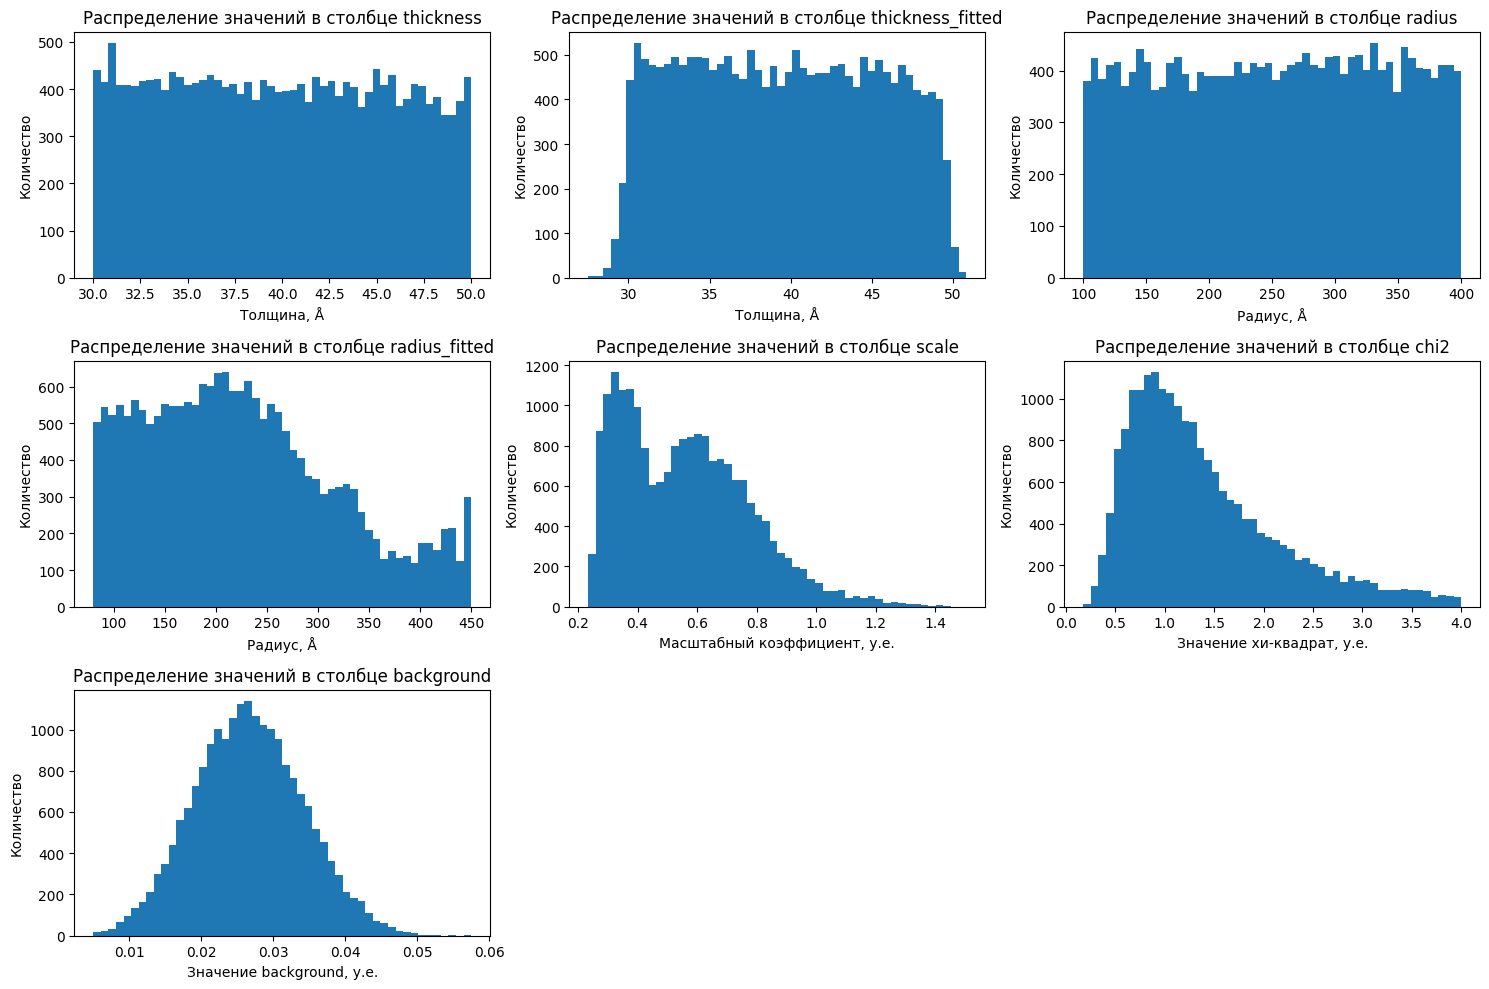

In [13]:
labels_dict1 = {
    'thickness': ['Распределение значений в столбце thickness', 'Толщина, Å', 'Количество'],
    'thickness_fitted': ['Распределение значений в столбце thickness_fitted', 'Толщина, Å', 'Количество'],
    'radius': ['Распределение значений в столбце radius', 'Радиус, Å', 'Количество'],
    'radius_fitted': ['Распределение значений в столбце radius_fitted', 'Радиус, Å', 'Количество'],
    'scale': ['Распределение значений в столбце scale', 'Масштабный коэффициент, у.е.', 'Количество'],
    'chi2': ['Распределение значений в столбце chi2', 'Значение хи-квадрат, у.е.', 'Количество'],
    'background': ['Распределение значений в столбце background', 'Значение background, у.е.', 'Количество']
}


plot_numbers(df_concat[['thickness', 'thickness_fitted', 'radius', 'radius_fitted', 'scale', 'chi2', 'background']], labels_dict1)

Данные для столцбов thickness, thickness_fitted и radius соответствуют равномерному распределению. В остальных случаях данные распределены неравномерно, в случае хи-квадрат - близко к нормальному. Параметры фитирования и рассчитанные структурные параметры липидных мембран распределены логично и ожидаемо, без аномалий. Видно, что для фитирования свободные параметры были ограничены в правильных диапазонах, так как при фитирование отсутствовала расходимость. Построим диаграммы "ящик с усами".

In [14]:
# Напишем функцию для построения диаграмм "ящик с усами"

def boxplot_numbers(df, labels_dict, nrows=3, ncols=3, figsize=(15, 10)):

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.ravel()

    for i, col in enumerate(labels_dict):
        df[col].plot.box(ax=axes[i])

        title, xlabel, ylabel = labels_dict.get(col)

        axes[i].set_title(f'Boxplot для столбца {col}')
        axes[i].set_ylabel(xlabel)

    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

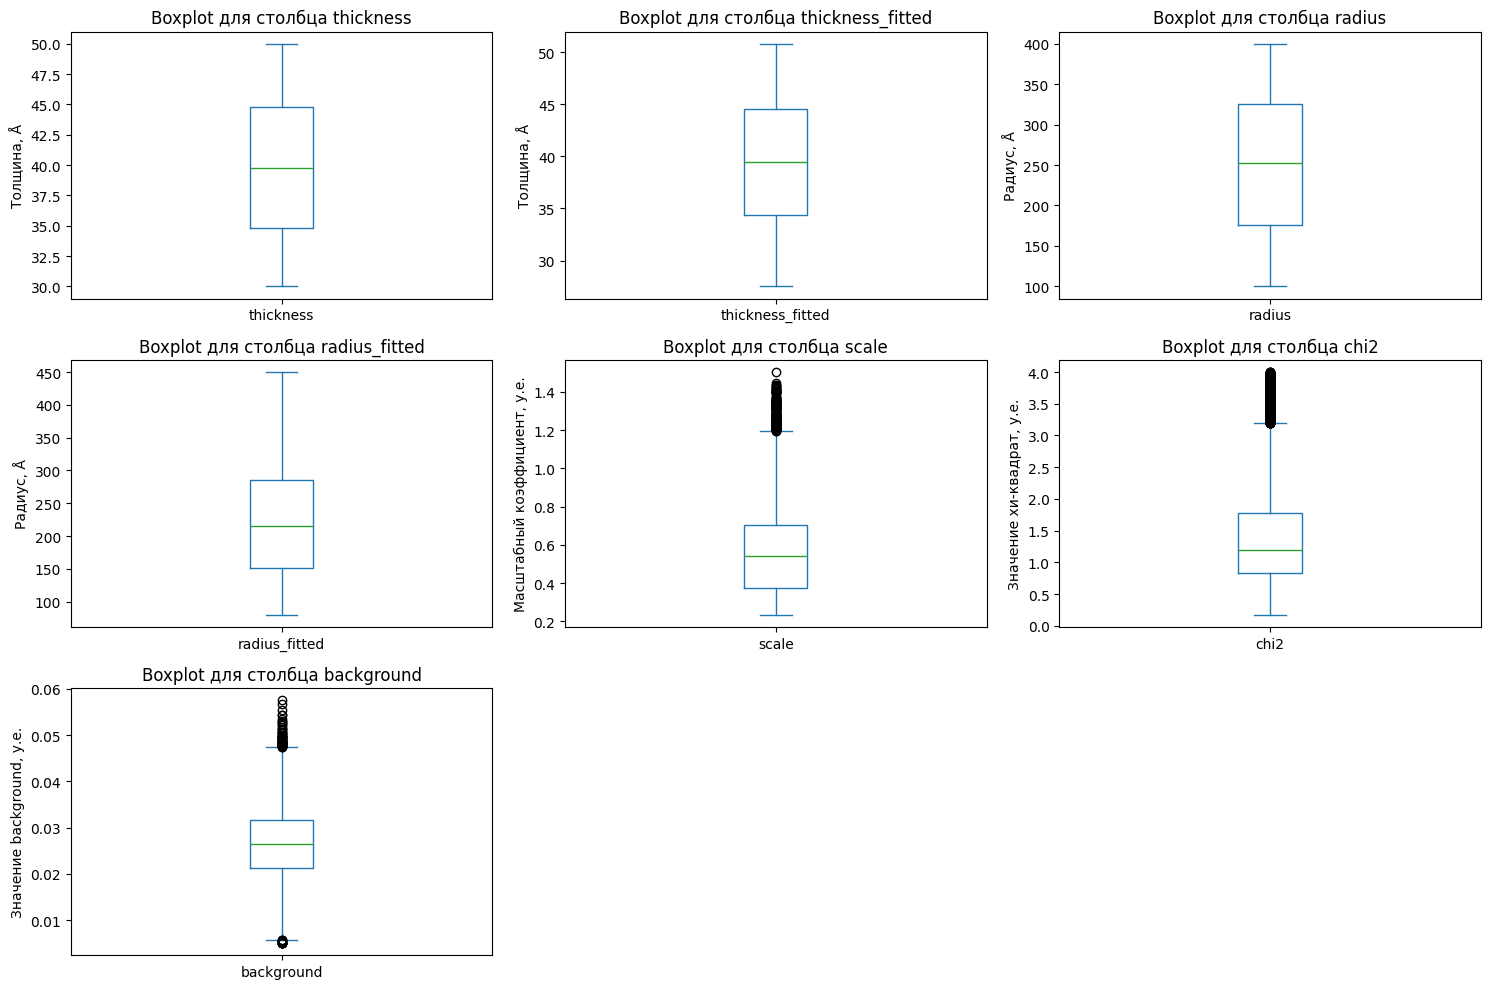

In [15]:
boxplot_numbers(df_concat[['thickness', 'thickness_fitted', 'radius', 'radius_fitted', 'scale', 'chi2', 'background']],
                labels_dict1)

Выбросы имеются только в столбцах хи-квадрат и background. Следовательно, полученные результаты по боксплотам подтверждают уже вышенаписанное.

Создадим развернутый датасет для анализа самих данных малоуглового рассеяния.

In [16]:
def create_analysis_dataframe(df, column='I'):

    all_values = []
    all_positions = []
    object_ids = []

    for idx, array_data in enumerate(df[column]):

        if isinstance(array_data, (list, np.ndarray)):
            array = np.array(array_data)
        else:
            array = parse_array_string(array_data)

        all_values.extend(array)
        all_positions.extend(range(len(array)))
        object_ids.extend([idx] * len(array))

    analysis_df = pd.DataFrame({
        'I_value': all_values,
        'q_position': all_positions,
        'object_id': object_ids
    })

    return analysis_df

In [17]:
analysis_df = create_analysis_dataframe(df_concat, column='I')

In [18]:
display(analysis_df.head())
display(analysis_df.tail())
display(analysis_df.info())

,I_value,q_position,object_id
0,295.440974,0,0
1,338.235120,1,0
2,358.586398,2,0
3,372.226378,3,0
4,340.622977,4,0


,I_value,q_position,object_id
2025795,0.041231,95,20257
2025796,0.041876,96,20257
2025797,0.037963,97,20257
2025798,0.021256,98,20257
2025799,0.027055,99,20257


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2025800 entries, 0 to 2025799
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   I_value     float64
 1   q_position  int64  
 2   object_id   int64  
dtypes: float64(1), int64(2)
memory usage: 46.4 MB


None

Выведем основную стат.информацию по интенсивности рассеянных нейронов для всех кривых рассеяния.

In [19]:
display(analysis_df['I_value'].describe())

,I_value
count,2.025800e+06
mean,3.801268e+01
std,7.147355e+01
min,1.812709e-03
25%,5.612342e-02
50%,3.160488e+00
75%,3.584422e+01
max,4.656671e+02


Рассчитаем основные стат.показатели по интенсивности I для каждой фиксированной точки q среди всех синтетических кривых.

In [20]:
q_stats = analysis_df.groupby('q_position')['I_value'].agg(['min', 'max', 'mean', 'std', 'median']).round(6)
print(q_stats.head(20))
print(q_stats.tail(20))

                   min         max        mean        std      median
q_position                                                           
0           173.660365  390.195060  300.222373  21.298524  300.159518
1           184.791830  390.734768  274.648090  24.846076  273.536800
2           150.936899  426.957105  252.477436  33.573981  250.500865
3           133.190221  420.132455  233.607306  42.723796  230.491571
4           106.590190  446.810283  216.980728  50.459987  212.940595
5            90.563646  462.233722  201.838959  56.132721  196.845860
6            73.385591  465.667066  187.978946  59.946929  183.460082
7            61.787753  456.209196  174.819668  61.942061  171.376266
8            51.624835  447.933326  162.631409  62.070999  160.856504
9            44.011123  430.895552  150.733932  60.842740  150.749893
10           37.835452  396.976497  139.348653  58.531242  140.275808
11           32.836970  396.465550  128.523476  55.228592  130.640109
12           28.5462

Визуализируем эти данные.

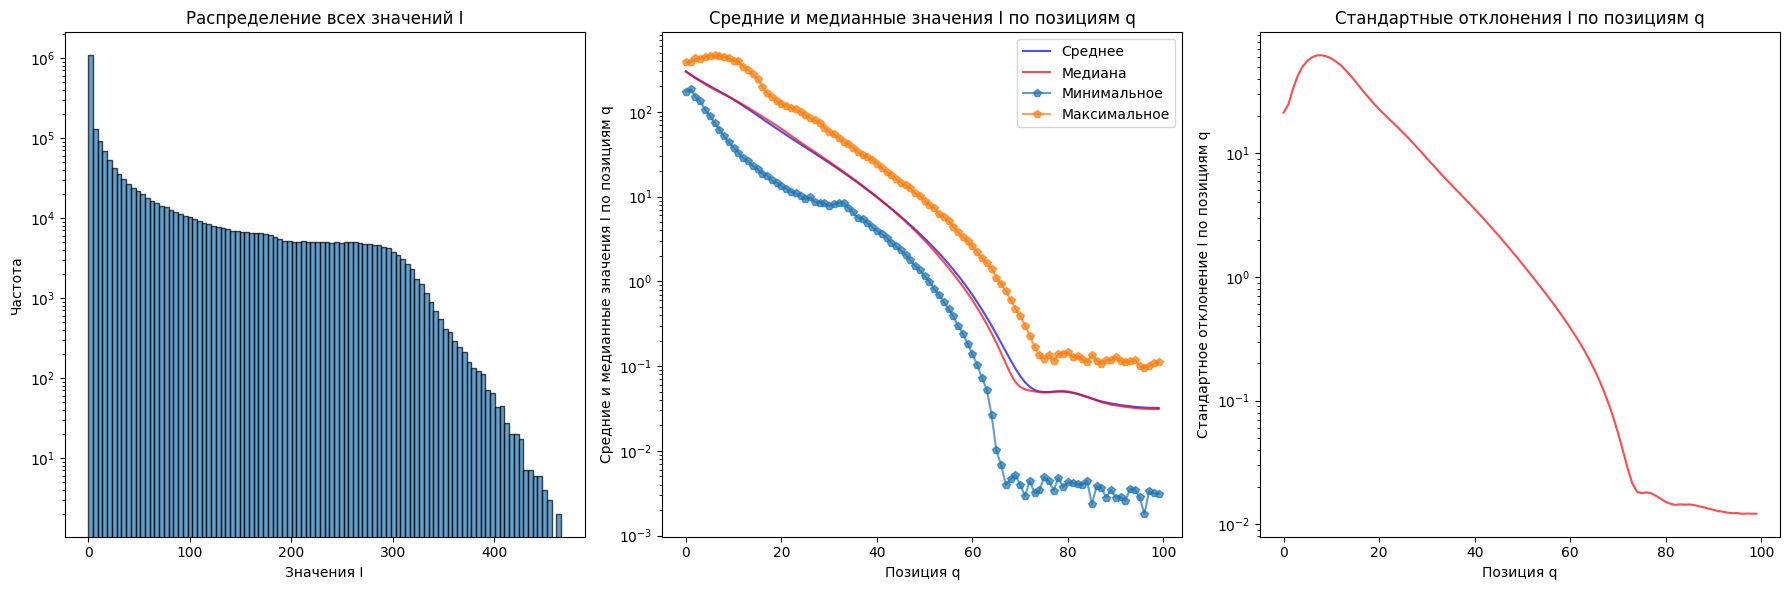

In [21]:

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Распределение всех значений I
axes[0].hist(analysis_df['I_value'], bins=100, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Значения I')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение всех значений I')
axes[0].set_yscale('log')

# Средние значения по I позициям q
q_means = analysis_df.groupby('q_position')['I_value'].mean()
q_medians = analysis_df.groupby('q_position')['I_value'].median()
q_min = analysis_df.groupby('q_position')['I_value'].min()
q_max = analysis_df.groupby('q_position')['I_value'].max()
axes[1].plot(q_means.index, q_means.values, 'b-', alpha=0.7, label='Среднее')
axes[1].plot(q_medians.index, q_medians.values, 'r-', alpha=0.7, label='Медиана')
axes[1].plot(q_min.index, q_min.values, 'p-', alpha=0.7, label='Минимальное')
axes[1].plot(q_max.index, q_max.values, 'p-', alpha=0.7, label='Максимальное')
axes[1].set_xlabel('Позиция q')
axes[1].set_ylabel('Средние и медианные значения I по позициям q')
axes[1].set_title('Средние и медианные значения I по позициям q')
axes[1].set_yscale('log')
axes[1].legend()

# Стандартные отклонения I по позициям q
q_stds = analysis_df.groupby('q_position')['I_value'].std()
axes[2].plot(q_stds.index, q_stds.values, 'r-', alpha=0.7)
axes[2].set_xlabel('Позиция q')
axes[2].set_ylabel('Стандартное отклонение I по позициям q')
axes[2].set_title('Стандартные отклонения I по позициям q')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

Распределения значений I равномерно в диапазоне 100 - 300. Выше значения 300 также имеются точки, однако их частота встречаемости уменьшается, что соответствует логике, заданной при генерации этих данных. Медианные и средние значения I по всем позициям q довольно близки, хотя видно расхождение в позициях 50 - 70 (медиана несколько меньше), т.е присутствуют выбросы. Именно эта область является ключевой для правильного определения толщины. Стандартное отклонение I максимально в начальных позициях q, что ожидаемо - эта область кривой отвечает за размеры липидных везикул и их полидисперсность.

Построим боксплоты для I при каждой позиции q.

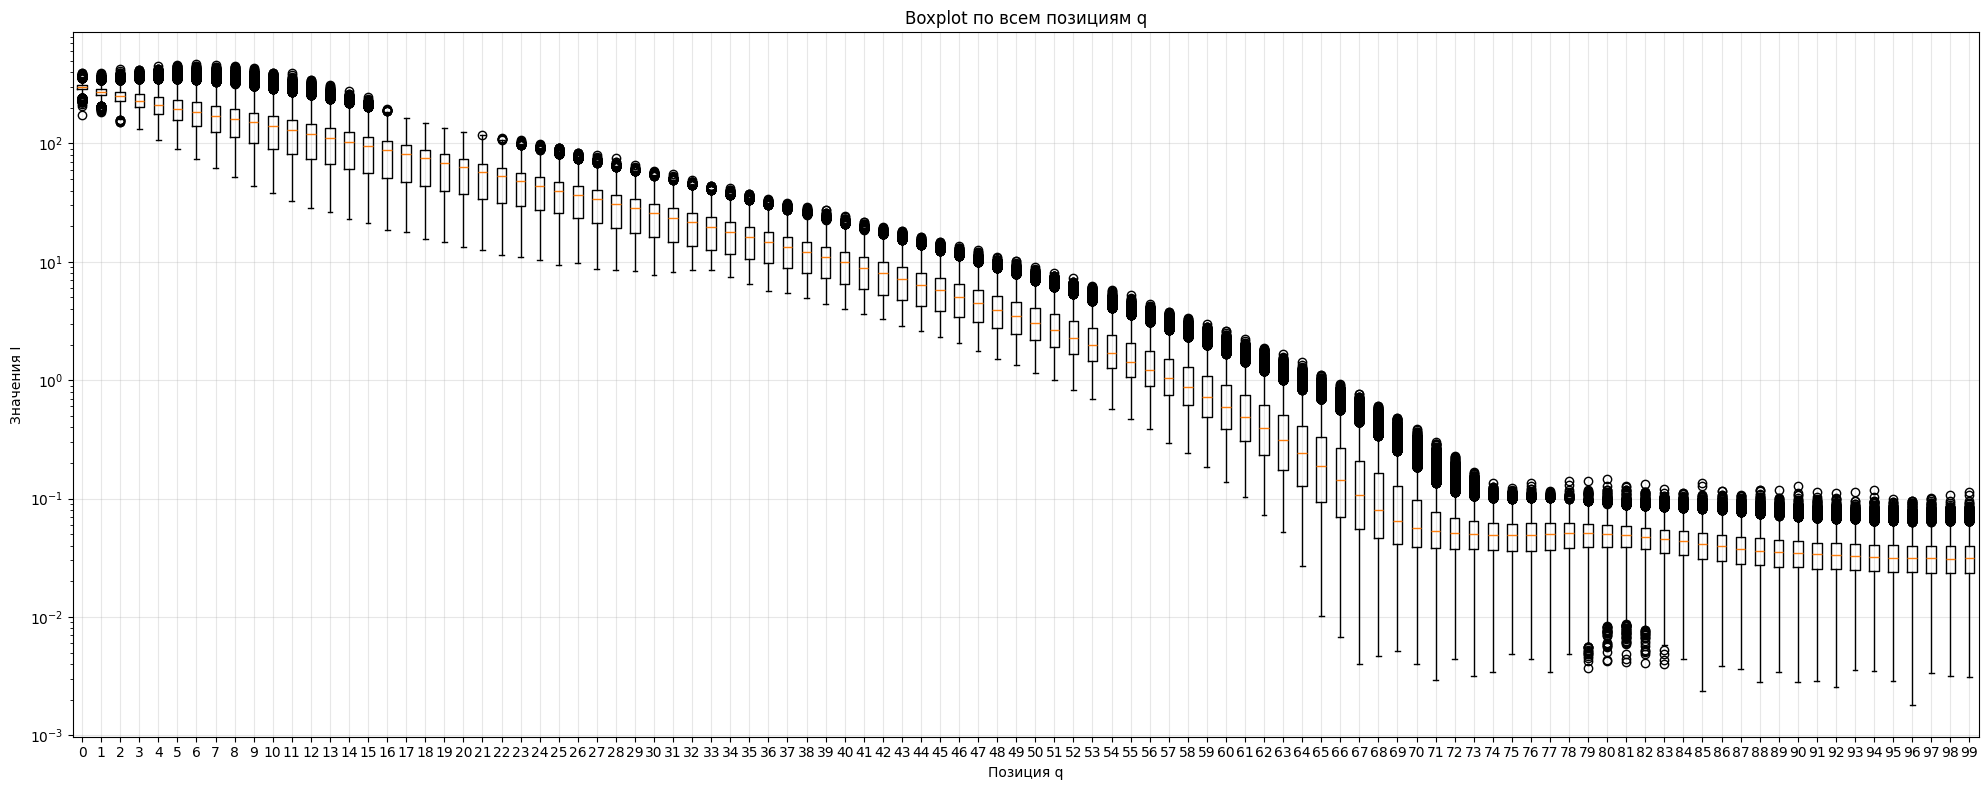

In [22]:
plt.figure(figsize=(20, 8))

all_positions = range(len(q_stats))
all_data = [analysis_df[analysis_df['q_position'] == pos]['I_value'].values
           for pos in all_positions]

plt.boxplot(all_data, positions=all_positions)
plt.xlabel('Позиция q')
plt.ylabel('Значения I')
plt.title('Boxplot по всем позициям q')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Действительно, в позициях 50 - 70 присутствуют небольшие выбросы. Однако в целом все кривые малоуглового рассеяния были сгенерированы успешно - они соответствуют реальным физическим кривым рассеяния.

**Вывод:**  
Произведена загрузка, обзор и анализ синтетических данных малоуглового рассеяния нейтронов на липидных везикулах. Отфильтрованы кривые с "сомнительными" результатами фитирования (относительно высоким значением хи-квадрат). В целом, кривые были сгенерированы успешно, отсутствуют аномальные значения интенсивностей и значений переданного импульса q.

## Тестовые реальные данные

Проведем анализ тестовых данных - реальных кривых малоуглового рассеяния нейтронов, полученных со спектрометра ЮМО

### Загрузка и обзор тестовых данных

In [23]:
dataset_for_test = pd.read_csv('/content/dataset_for_test.csv')

display(dataset_for_test.head())
display(dataset_for_test.info())

,filename,q_angstrom,I,errors_I,scale,Chi2,thickness_fitted,radius_fitted,background
0,DPPC_DOPC_1_1_ab_1_42_t20d.dat,[0.0083886 0.00873108 0.00908754 0.00945855 0...,[3.00000000e+02 2.75303945e+02 2.69139624e+02 ...,[5.4506e+01 7.4010e+01 4.2771e+01 5.1226e+01 2...,0.161924,1.666428,41.158083,466.325971,0.006498
1,iv_dmpc__ab25_t60_1a.dat,[0.0083886 0.00873108 0.00908754 0.00945855 0...,[3.00000000e+02 2.89892727e+02 2.62681613e+02 ...,[1.3612e+01 1.2045e+01 1.4052e+01 8.1749e+00 8...,0.150485,2.180743,35.476473,596.685655,0.013749
2,4iv_dppc_01ab42_100d2o_t38_1a.dat,[0.0083886 0.00873108 0.00908754 0.00945855 0...,[3.00000000e+02 2.02745892e+02 1.90727767e+02 ...,[8.2269e+01 3.3470e+01 3.7588e+01 2.5086e+01 1...,0.124521,1.054322,43.701041,483.853224,0.005694
3,iv_dlpc__pure_t70_3a.dat,[0.0083886 0.00873108 0.00908754 0.00945855 0...,[3.00000000e+02 2.72140582e+02 2.41677473e+02 ...,[1.0055e+01 8.2533e+00 9.3694e+00 5.5656e+00 6...,0.113629,2.352047,31.484530,497.249643,0.012754
4,DOPC_ULV_t50.dat,[0.0083886 0.00873108 0.00908754 0.00945855 0...,[ 3.00000000e+02 3.19956044e+02 2.47331104e+...,[2.9649e+01 4.0027e+01 5.1508e+01 2.7596e+01 2...,0.138040,2.889449,36.963145,438.876122,0.003078


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   filename          501 non-null    object 
 1   q_angstrom        501 non-null    object 
 2   I                 501 non-null    object 
 3   errors_I          501 non-null    object 
 4   scale             501 non-null    float64
 5   Chi2              501 non-null    float64
 6   thickness_fitted  501 non-null    float64
 7   radius_fitted     501 non-null    float64
 8   background        501 non-null    float64
dtypes: float64(5), object(4)
memory usage: 35.4+ KB


None

In [24]:
display(dataset_for_test.duplicated().sum())
display(dataset_for_test.isna().sum().sum())

np.int64(0)

np.int64(0)

Данные со слишком высоким значением хи-квадрат в тестовой выборке должны быть обязательно исключены, так как фитирование таких кривых оказалось проблемным, и значение толщины может быть неправильным. Исключим из выборки значения хи-квадрат больше 7.

In [25]:
dataset_for_test = dataset_for_test[dataset_for_test['Chi2'] < 7]

dataset_for_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 468 entries, 0 to 500
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   filename          468 non-null    object 
 1   q_angstrom        468 non-null    object 
 2   I                 468 non-null    object 
 3   errors_I          468 non-null    object 
 4   scale             468 non-null    float64
 5   Chi2              468 non-null    float64
 6   thickness_fitted  468 non-null    float64
 7   radius_fitted     468 non-null    float64
 8   background        468 non-null    float64
dtypes: float64(5), object(4)
memory usage: 36.6+ KB


Таким образом, в тестовом датасете остается 468 кривых малоуглового рассеяния. Датасет размечен. Дубликаты и пропуски отсутствуют.

### Обработка и анализ тестовых данных

Сделаем парсинг данных в столбце I. Затем проанализируем распределение значений в столбцах датасета и распределение значений в столбце I по позициям q аналогично датасету с синтетическими кривыми.

In [26]:
dataset_for_test['I'] = dataset_for_test['I'].apply(parse_array_string)

first_element = dataset_for_test['I'].iloc[0]
display(len(first_element))
display(first_element[:10])

dataset_for_test['I'] = dataset_for_test['I'].apply(lambda x: np.array(x) if isinstance(x, list) else x)

100

[300.0,
 275.303945,
 269.139624,
 259.780479,
 262.011666,
 222.142347,
 235.647814,
 175.347422,
 182.43382,
 166.038994]

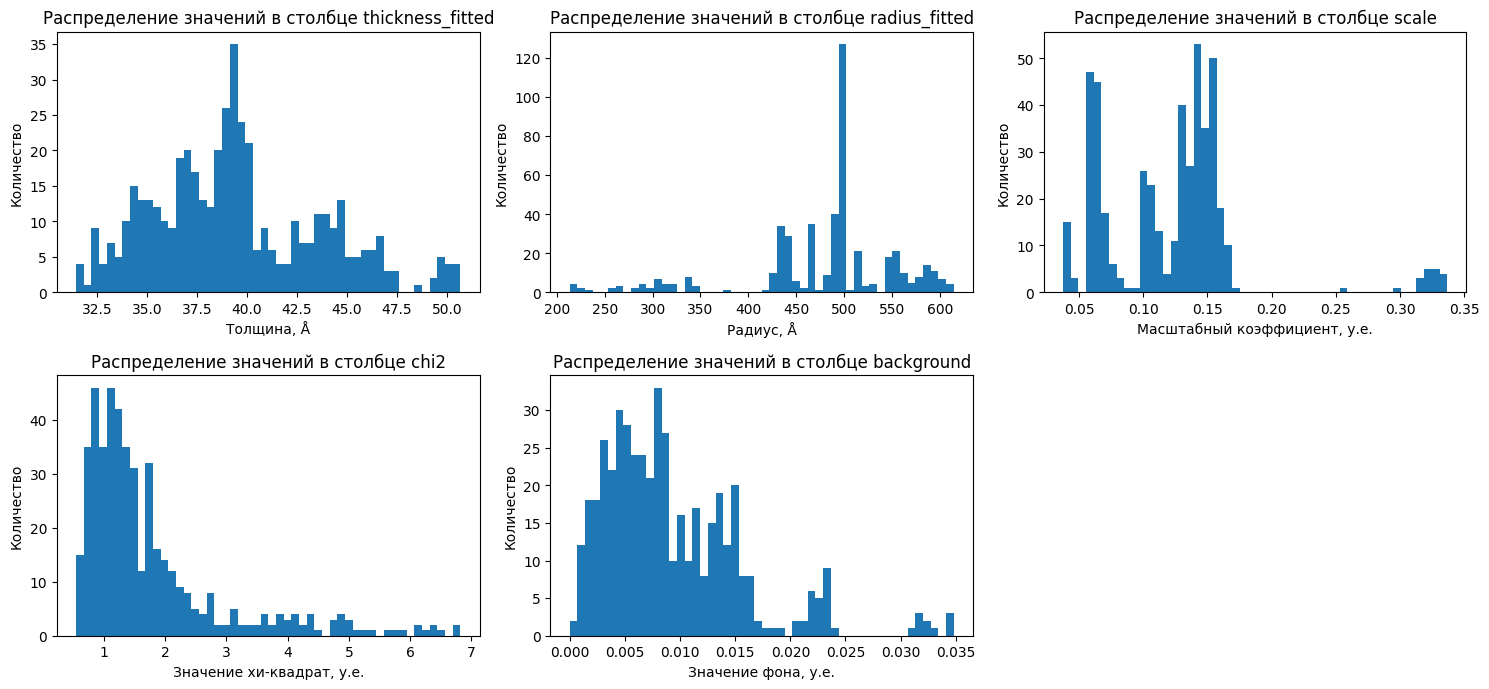

In [27]:

labels_dict2 = {
    'thickness_fitted': ['Распределение значений в столбце thickness_fitted', 'Толщина, Å', 'Количество'],
    'radius_fitted': ['Распределение значений в столбце radius_fitted', 'Радиус, Å', 'Количество'],
    'scale': ['Распределение значений в столбце scale', 'Масштабный коэффициент, у.е.', 'Количество'],
    'Chi2': ['Распределение значений в столбце chi2', 'Значение хи-квадрат, у.е.', 'Количество'],
    'background': ['Распределение значений в столбце background', 'Значение фона, у.е.', 'Количество']
}


plot_numbers(dataset_for_test[['thickness_fitted', 'radius_fitted', 'scale', 'Chi2', 'background']], labels_dict2)

Распределение значений thickness в тестовом датасете неравномерное, однако значения соответствуют значениям thickness_fitted синтетических кривых, т.е. находятся практически в аналогичном диапазоне. Распределение значений в остальных столбцах в целом корректное.

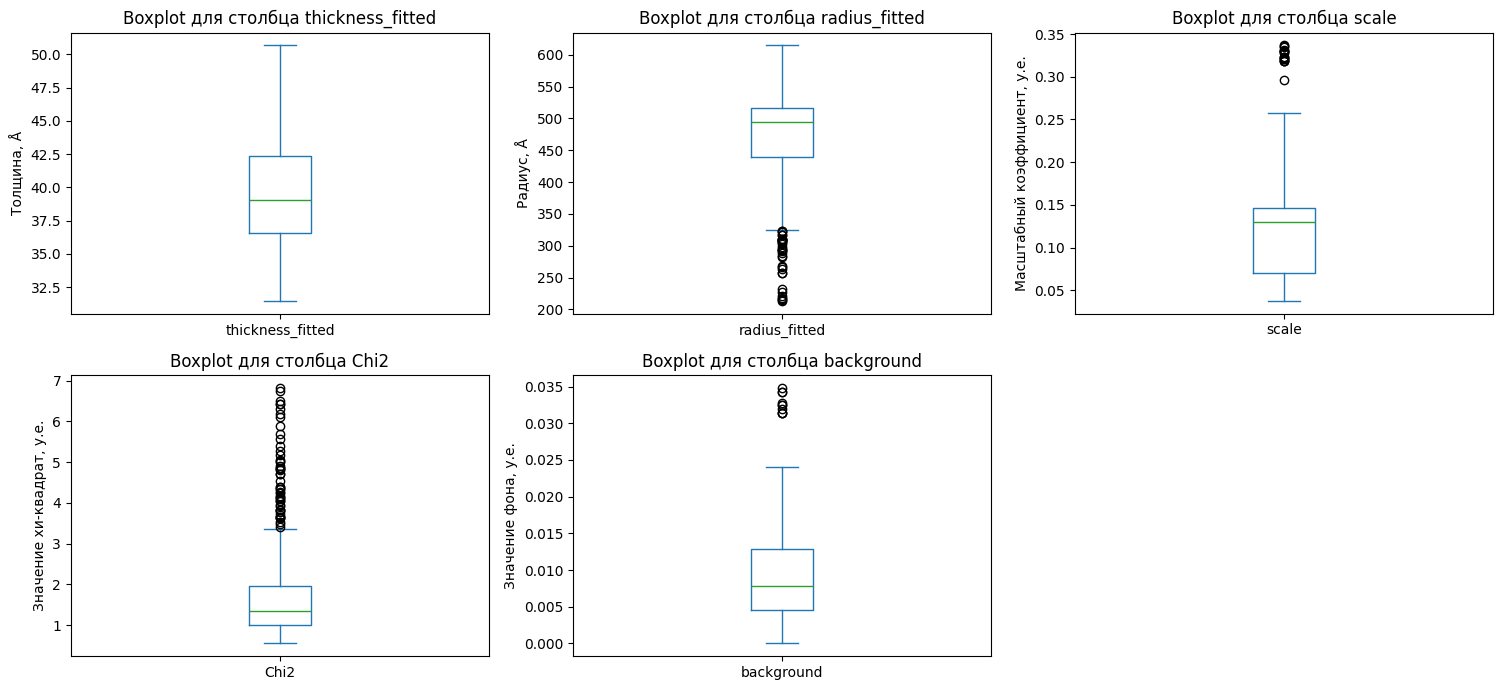

In [28]:
boxplot_numbers(dataset_for_test[['thickness_fitted', 'radius_fitted', 'scale', 'Chi2', 'background']],
                labels_dict2, nrows=2, ncols=3, figsize=(15, 7))

Создадим датасет, общий по точкам q, для анализа распределений I по каждому значению q.

In [29]:
analysis_df_test = create_analysis_dataframe(dataset_for_test, column='I')

In [30]:
display(analysis_df_test['I_value'].describe())

,I_value
count,46800.000000
mean,36.335123
std,66.278023
min,-0.130107
25%,0.079952
50%,3.210701
75%,39.045498
max,409.301506


In [31]:
q_stats_test = analysis_df_test.groupby('q_position')['I_value'].agg(['min', 'max', 'mean', 'std', 'median']).round(6)
print(q_stats_test.head(20))
print(q_stats_test.tail(20))

                   min         max        mean        std      median
q_position                                                           
0           300.000000  300.000000  300.000000   0.000000  300.000000
1           147.810792  409.301506  263.325928  55.848193  271.719784
2            99.290596  375.930905  230.014696  42.621820  234.964312
3           139.764006  381.143342  220.646466  45.161742  209.639430
4           109.400700  407.170004  201.737623  54.561610  194.925371
5           110.501529  305.596926  181.208547  34.603902  177.973629
6           102.080063  330.559144  173.445571  44.388672  164.877857
7            89.628175  287.576606  159.784661  38.950620  155.171118
8            91.057292  263.507808  152.454754  33.906425  146.893792
9            82.697164  248.056573  139.558200  29.251682  135.337302
10           76.674630  220.168681  129.430689  27.200032  124.871034
11           73.096955  208.692528  121.307880  23.855239  118.249450
12           66.0305

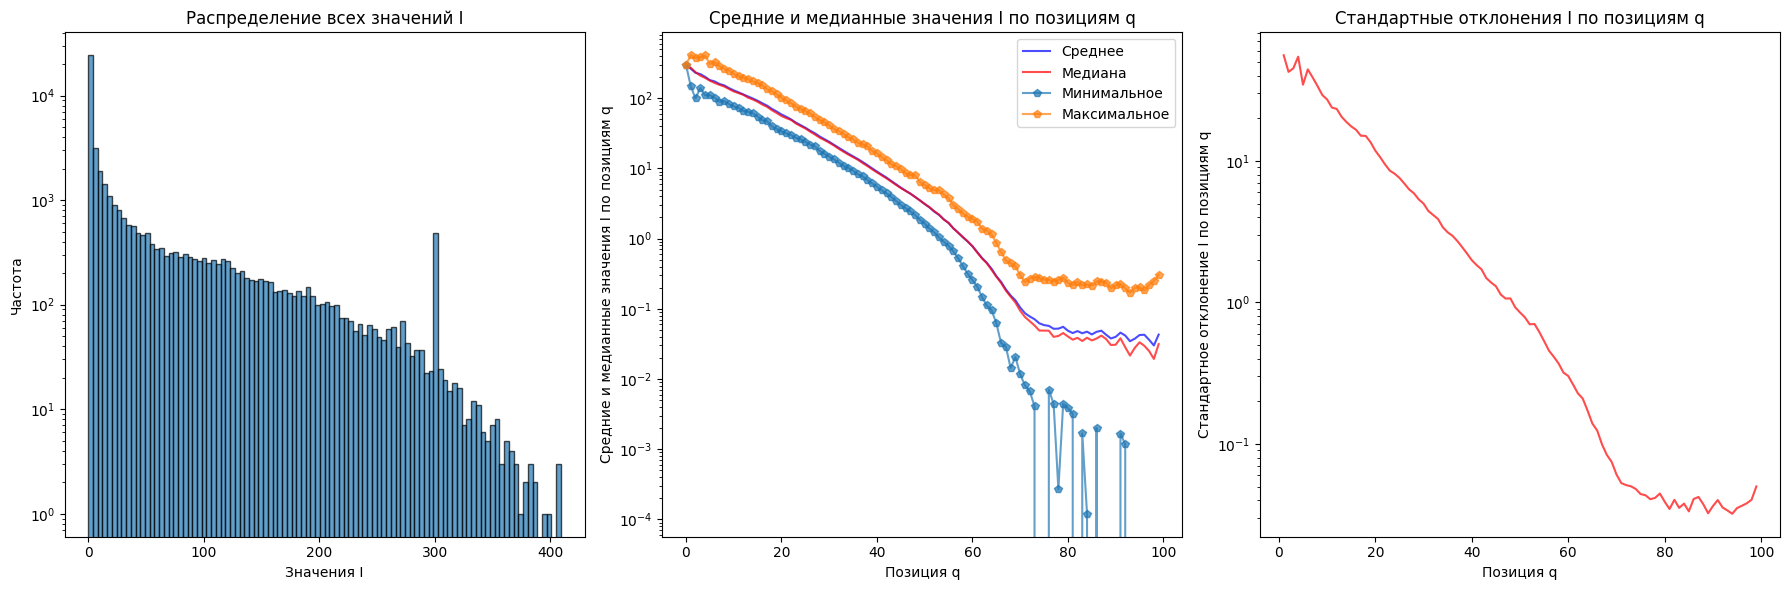

In [32]:

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Распределение всех значений I
axes[0].hist(analysis_df_test['I_value'], bins=100, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Значения I')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение всех значений I')
axes[0].set_yscale('log')

# Средние значения по I позициям q
q_means_test = analysis_df_test.groupby('q_position')['I_value'].mean()
q_medians_test = analysis_df_test.groupby('q_position')['I_value'].median()
q_min_test = analysis_df_test.groupby('q_position')['I_value'].min()
q_max_test = analysis_df_test.groupby('q_position')['I_value'].max()
axes[1].plot(q_means_test.index, q_means_test.values, 'b-', alpha=0.7, label='Среднее')
axes[1].plot(q_medians_test.index, q_medians_test.values, 'r-', alpha=0.7, label='Медиана')
axes[1].plot(q_min_test.index, q_min_test.values, 'p-', alpha=0.7, label='Минимальное')
axes[1].plot(q_max_test.index, q_max_test.values, 'p-', alpha=0.7, label='Максимальное')
axes[1].set_xlabel('Позиция q')
axes[1].set_ylabel('Средние и медианные значения I по позициям q')
axes[1].set_title('Средние и медианные значения I по позициям q')
axes[1].set_yscale('log')
axes[1].legend()

# Стандартные отклонения I по позициям q
q_stds_test = analysis_df_test.groupby('q_position')['I_value'].std()
axes[2].plot(q_stds_test[1:].index, q_stds_test[1:].values, 'r-', alpha=0.7)
axes[2].set_xlabel('Позиция q')
axes[2].set_ylabel('Стандартное отклонение I по позициям q')
axes[2].set_title('Стандартные отклонения I по позициям q')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

При сравнении тестовых реальных данных с синтетическими данными видно, что в сейчас в случае тестовых данных частота распределений интенсивностей имеет схожую с синтетическими данными форму распределения. Однако среднее и медианное значения различаются только при относительно высоких q (с 70-й позиции) в отличие от синтетических данных, что говорит о том, что в тестовых данных количество кривых с относительно выскоим фоном несколько больше кривых с низким фоном. Также могут присутствовать кривые с сильным шумом при высоких q (синие точки). Построим боксплоты по всем позициям q.

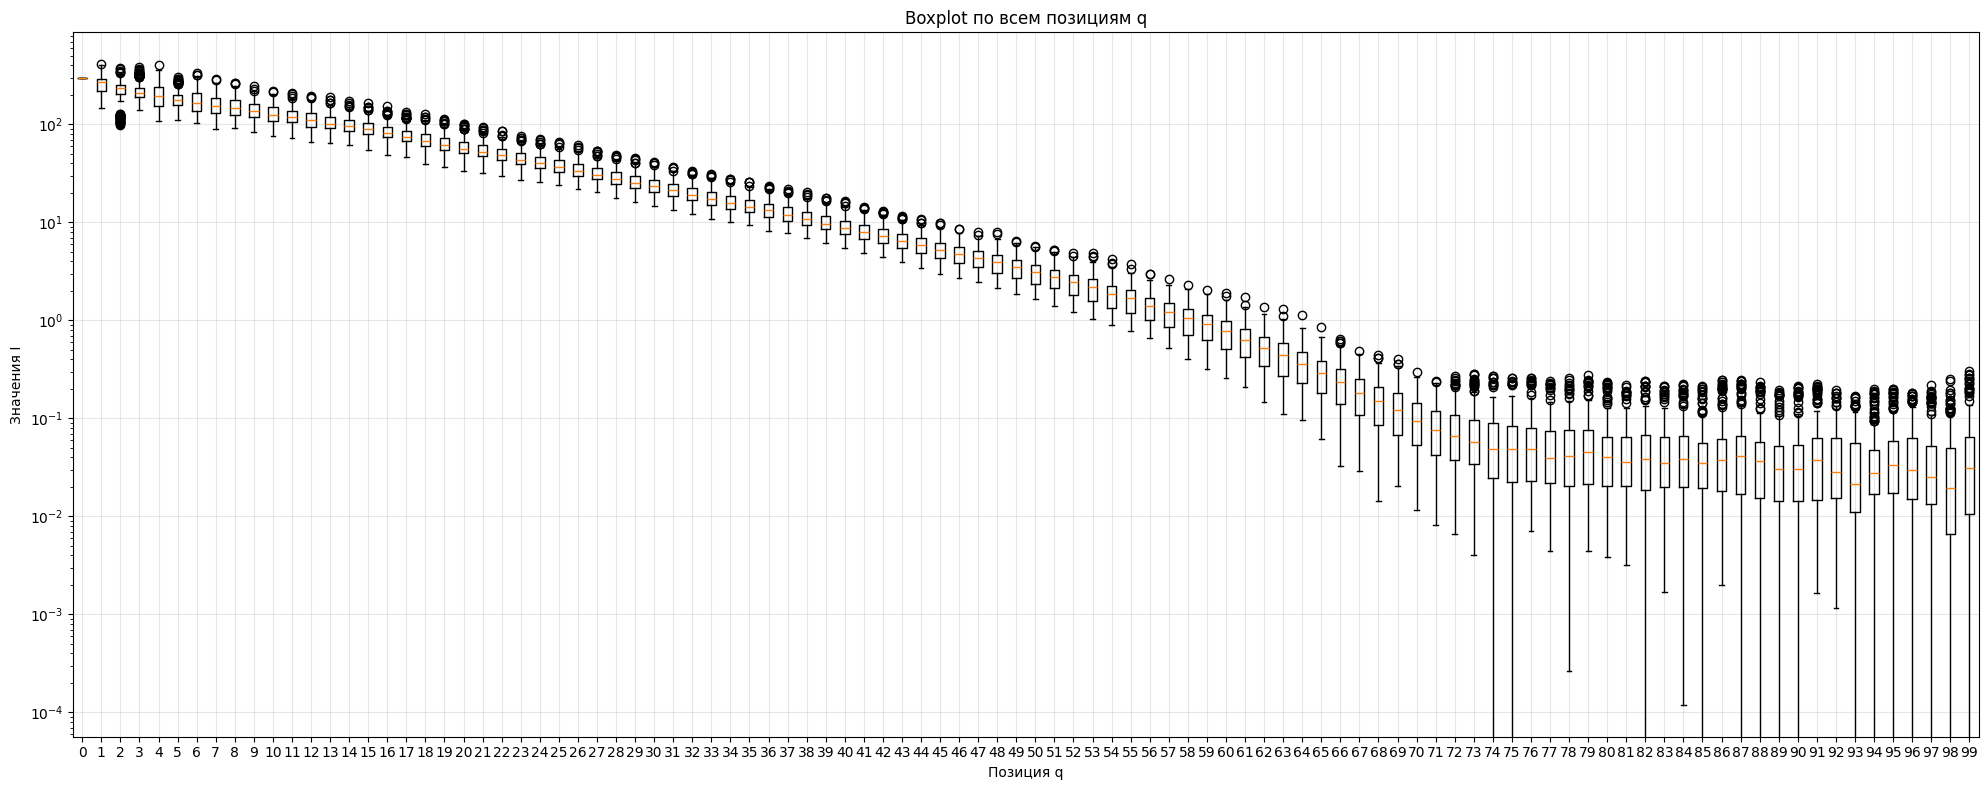

In [33]:
plt.figure(figsize=(20, 8))

all_positions_test = range(len(q_stats_test))
all_data_test = [analysis_df_test[analysis_df_test['q_position'] == pos]['I_value'].values
           for pos in all_positions_test]

plt.boxplot(all_data_test, positions=all_positions_test)
plt.xlabel('Позиция q')
plt.ylabel('Значения I')
plt.title('Boxplot по всем позициям q')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Тестовые реальные данные малоуглового рассеяния демонстрируют отсутствие аномалий. Заметно, что при относительно высоких значениях q (позиции примерно выше 70) боксплоты имеют сильный размах, т.е. данные в этой области довольно шумные, что ожидаемо в силу высокого фона установки малоуглового рассеяния нейтронов ЮМО и разнообразия измеренных образцов. Наложим боксплоты синтетических кривых и реальных кривых:

## Сравнение синтетических и реальных кривых рассеяния

Проведем визуальное сравнение синтетических и реальных кривых малоуглового рассеяния нейтронов на липидных везикулах

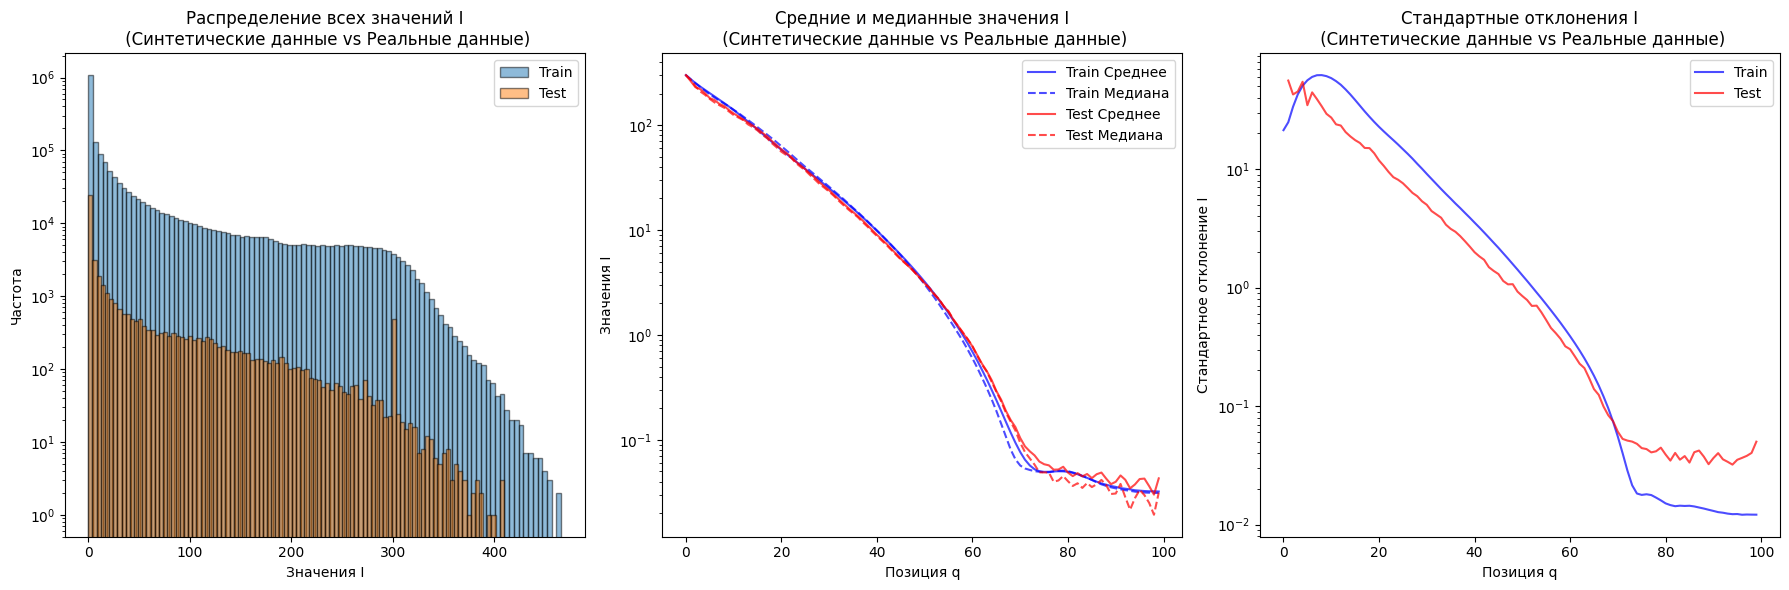

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))


axes[0].hist(analysis_df['I_value'], bins=100, alpha=0.5, edgecolor='black', label='Train')
axes[0].hist(analysis_df_test['I_value'], bins=100, alpha=0.5, edgecolor='black', label='Test')
axes[0].set_xlabel('Значения I')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение всех значений I\n (Синтетические данные vs Реальные данные)')
axes[0].set_yscale('log')
axes[0].legend()


q_means = analysis_df.groupby('q_position')['I_value'].mean()
q_medians = analysis_df.groupby('q_position')['I_value'].median()
q_means_test = analysis_df_test.groupby('q_position')['I_value'].mean()
q_medians_test = analysis_df_test.groupby('q_position')['I_value'].median()

axes[1].plot(q_means.index, q_means.values, 'b-', alpha=0.7, label='Train Среднее')
axes[1].plot(q_medians.index, q_medians.values, 'b--', alpha=0.7, label='Train Медиана')
axes[1].plot(q_means_test.index, q_means_test.values, 'r-', alpha=0.7, label='Test Среднее')
axes[1].plot(q_medians_test.index, q_medians_test.values, 'r--', alpha=0.7, label='Test Медиана')
axes[1].set_xlabel('Позиция q')
axes[1].set_ylabel('Значения I')
axes[1].set_title('Средние и медианные значения I\n (Синтетические данные vs Реальные данные)')
axes[1].set_yscale('log')
axes[1].legend()


q_stds = analysis_df.groupby('q_position')['I_value'].std()
q_stds_test = analysis_df_test.groupby('q_position')['I_value'].std()

axes[2].plot(q_stds.index, q_stds.values, 'b-', alpha=0.7, label='Train')
axes[2].plot(q_stds_test[1:].index, q_stds_test[1:].values, 'r-', alpha=0.7, label='Test')
axes[2].set_xlabel('Позиция q')
axes[2].set_ylabel('Стандартное отклонение I')
axes[2].set_title('Стандартные отклонения I\n (Синтетические данные vs Реальные данные)')
axes[2].set_yscale('log')
axes[2].legend()

plt.tight_layout()
plt.show()

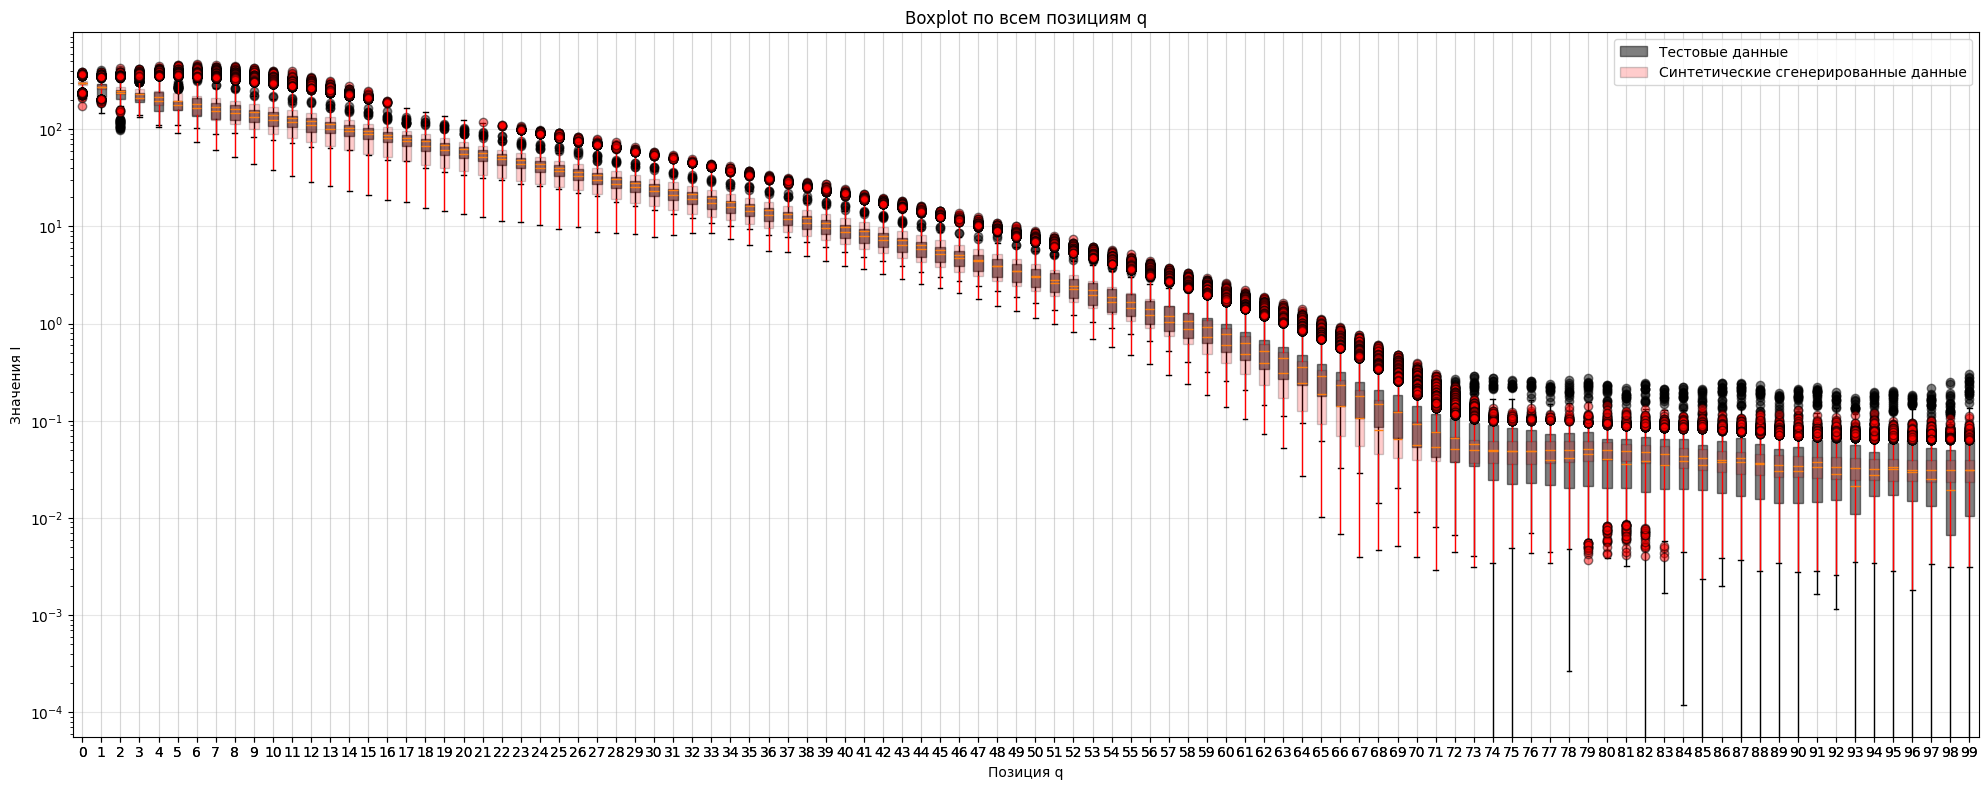

In [35]:
plt.figure(figsize=(20, 8))

plt.boxplot(all_data_test,
            positions=all_positions_test,
            patch_artist=True,
            boxprops=dict(facecolor='black', alpha=0.5),
            whiskerprops=dict(color='black'),
            flierprops=dict(marker='o', markerfacecolor='black', alpha=0.5),
            label='Тестовые данные')

plt.boxplot(all_data,
            positions=all_positions,
            patch_artist=True,
            boxprops=dict(facecolor='red', alpha=0.2),
            whiskerprops=dict(color='red'),
            flierprops=dict(marker='o', markerfacecolor='red', alpha=0.5),
            label='Синтетические сгенерированные данные')

plt.xlabel('Позиция q')
plt.ylabel('Значения I')
plt.title('Boxplot по всем позициям q')
plt.yscale('log')
plt.grid(True, alpha=0.3)

# Добавляем легенду (чтобы отобразились метки из label)
plt.legend()

plt.tight_layout()
plt.show()

Видно, что синтетические данные покрыли почти весь интервал интенсивностей I тестовой выборки практически на всем диапазоне по q, что обуславливает неплохую аугментацию синтетических данных, хотя шумы и фон синтетических кривых выражены слабее (диапазон по q примерно от 70)

**Вывод:**  
Произведена загрузка, обзор и анализ реальных данных малоуглового рассеяния нейтронов на липидных везикулах (данные со спеткрометра ЮМО), предназначенные для тестовой выборки. Отфильтрованы кривые с "сомнительными" результатами фитирования (относительно высоким значением хи-квадрат). Синтетические данные кривых рассеяния покрыли почти весь интервал интенсивностей I тестовой выборки реальных кривых рассеяния практически на всем диапазоне по q, хотя вариативность при относительно высоких q в тестовых данных все-таки несколько выше.

## Обучение нейросети

Проведем разделение синтетического датасета (кривых) на тренировочную и валидационную выборки. В простую полносвязную нейронную сеть с четырьмя скрытыми слоями будем подавать массивы I. Целевой признак - thickness_fitted (задача регрессии). Функция потерь - MSE, метрика - MAE, оптимизатор - Adam. Также при построении нейронной сети используем регуляризацию.

In [36]:
train_df, val_df = train_test_split(df_concat, test_size=0.2, random_state=42)

In [37]:
# Преобразуем списки в numpy массивы
X_train = np.array([np.array(curve) for curve in train_df['I']])
X_val = np.array([np.array(curve) for curve in val_df['I']])


y_train = np.array(train_df['thickness_fitted'])
y_val = np.array(val_df['thickness_fitted'])

# Проверим размерности
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")

X_train: (16206, 100)
X_val: (4052, 100)
y_train: (16206,)
y_val: (4052,)


In [38]:
# Масштабируем признаки X
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [39]:
# Создание модели
def create_sans_nn(input_dim=100):
    model = keras.Sequential([
        layers.Dense(256, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.6),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(16, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1, activation='linear')
    ])


    optimizer = keras.optimizers.Adam(learning_rate=0.0005)

    model.compile(
        optimizer=optimizer,
        loss=['mse'],
        metrics=['mae']
    )

    return model

model = create_sans_nn(input_dim=100)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,617 (279.75 KB)

 Trainable params: 70,625 (275.88 KB)

 Non-trainable params: 992 (3.88 KB)

Запустим обучение на 100 эпох. Используем "коллбэки" в обучении нейросети с остановкой обучения и понижением скорости обучения.

In [40]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=256,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 1577.2854 - mae: 39.3837 - val_loss: 1528.9196 - val_mae: 38.7745 - learning_rate: 5.0000e-04
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1553.9019 - mae: 39.2841 - val_loss: 1535.2742 - val_mae: 38.9957 - learning_rate: 5.0000e-04
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1522.2738 - mae: 38.9485 - val_loss: 1530.0691 - val_mae: 39.0038 - learning_rate: 5.0000e-04
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1502.8788 - mae: 38.7277 - val_loss: 1493.2389 - val_mae: 38.5735 - learning_rate: 5.0000e-04
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1474.2318 - mae: 38.3633 - val_loss: 1472.9143 - val_mae: 38.3332 - learning_rate: 5.0000e-04
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1440.8584 - mae: 37.9263 - val_loss: 1412.0862 - val_mae: 37.5447 - learning_rate: 5.0000e-04
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1401.5143 - mae:

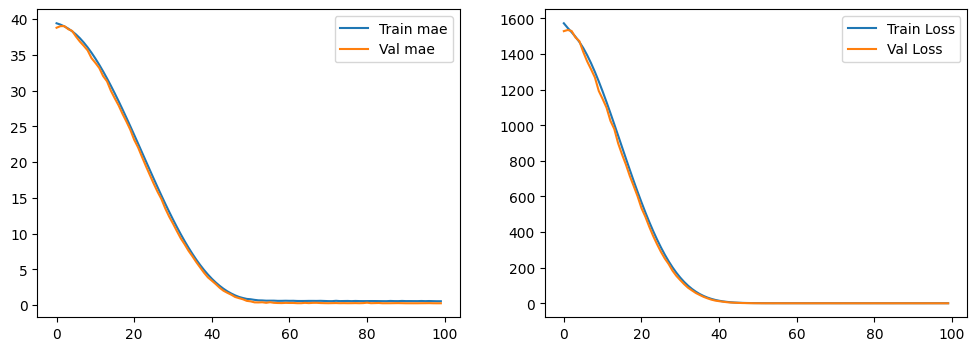

In [41]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Train mae')
plt.plot(history.history['val_mae'], label='Val mae')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

Нейронная сеть успешно обучилась на 100 эпохах, значения лосс-функций и метрики MAE для тренировочных и валидационных данных стабильно снизились и вышли на плато. MAE на тренировочной выборке - около , на валидационной - .

**Вывод:**  
Нейронная сеть успешно обучилась на 100 эпохах, значения лосс-функций и метрики MAE для тренировочных и валидационных данных стабильно снизились и вышли на плато.

## Тестирование модели

Тестирование модели будет идти на реальных данных со спектрометра ЮМО. Напишем функцию, в которой происходит нормировка входных тестовых данных, масштабирование, предсказание результата и расчет значения метрики MAE. Составим из рассчитанных значений датасет и выведем его первые строки.

In [42]:
def evaluate_model_on_test_set(model, scaler, test_df):

    test_df['q_angstrom'] = test_df['q_angstrom'].apply(parse_array_string)

    X_test = []
    y_true = []
    filenames = []

    for _, row in test_df.iterrows():

        # Подготовка данных для модели
        I_values = np.array(row['I']).reshape(1, -1)

        # Нормализация
        I_normalized = scaler.transform(I_values)

        X_test.append(I_normalized[0])
        y_true.append(row['thickness_fitted'])
        filenames.append(row['filename'])

    X_test = np.array(X_test)
    y_true = np.array(y_true)

    # Предсказание
    y_pred = model.predict(X_test, verbose=0).flatten() * 1.077

    # Расчет MAE
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Создаем датасет с результатами
    results_df = pd.DataFrame({
        'filename': filenames,
        'true_thickness': y_true,
        'predicted_thickness': y_pred,
        'absolute_error': np.abs(y_true - y_pred)
          })

    print(f"MAE на тестовой выборке: {mae:.3f} А")
    print(f"r2 на тестовой выборке: {r2:.3f}")
    print(f"Количество объектов: {len(y_true)}")

    return mae, results_df, y_true, y_pred, X_test

In [43]:
mae, results, y_true, y_pred, X_test = evaluate_model_on_test_set(
    model=model,
    scaler=scaler,
    test_df=dataset_for_test
)

MAE на тестовой выборке: 0.823 А
r2 на тестовой выборке: 0.938
Количество объектов: 468


Посмотрим на работу фиктивной модели.

In [44]:
# Инициализируем DummyRegressor

dummy = DummyRegressor()
dummy.fit(X_train_scaled, y_train)

y_pred_dummy = dummy.predict(X_test)

print(f'Метрика MAE фиктивной модели: {round(mean_absolute_error(y_true, y_pred_dummy), 2)} A')

Метрика MAE фиктивной модели: 3.29 A


Значение MAE 0.82 ангстрем и r2 в 0.938 на тестовой выборке - достаточно хороший результат на реальных данных со спектрометра малоуглового рассеяния, как с точки зрения и точности, с которой можно определять толщину мембран в везикулах, так и с точким зрения метрики MAE, полученной на фиктивной модели.

In [45]:
results.head(10)

,filename,true_thickness,predicted_thickness,absolute_error
0,DPPC_DOPC_1_1_ab_1_42_t20d.dat,41.158083,41.613476,0.455393
1,iv_dmpc__ab25_t60_1a.dat,35.476473,34.303875,1.172598
2,4iv_dppc_01ab42_100d2o_t38_1a.dat,43.701041,44.268051,0.567010
3,iv_dlpc__pure_t70_3a.dat,31.484530,31.925865,0.441335
4,DOPC_ULV_t50.dat,36.963145,36.219261,0.743884
5,iv_dppc_05Ab42_t40_2b.dat,41.614265,42.118023,0.503758
6,DMPC_pure_t50a_3.dat,34.736429,34.795280,0.058851
7,iv_dmpcA_Ab25_t40_1a.dat,37.452892,35.083412,2.369480
8,iv_dmpcB_Ab42_t70_1a.dat,34.032119,33.139263,0.892856
9,iv_dppc_05ab42_100d2o_t20_1a.dat,47.150131,47.649853,0.499721


Построим график, визуализирующий фактические значения толщины липидных мембран на тестовой выборке и предсказанные значения. Построим линию идеального предсказания, а также инициализируем модель линейной регрессии и аппроксимируем данные.

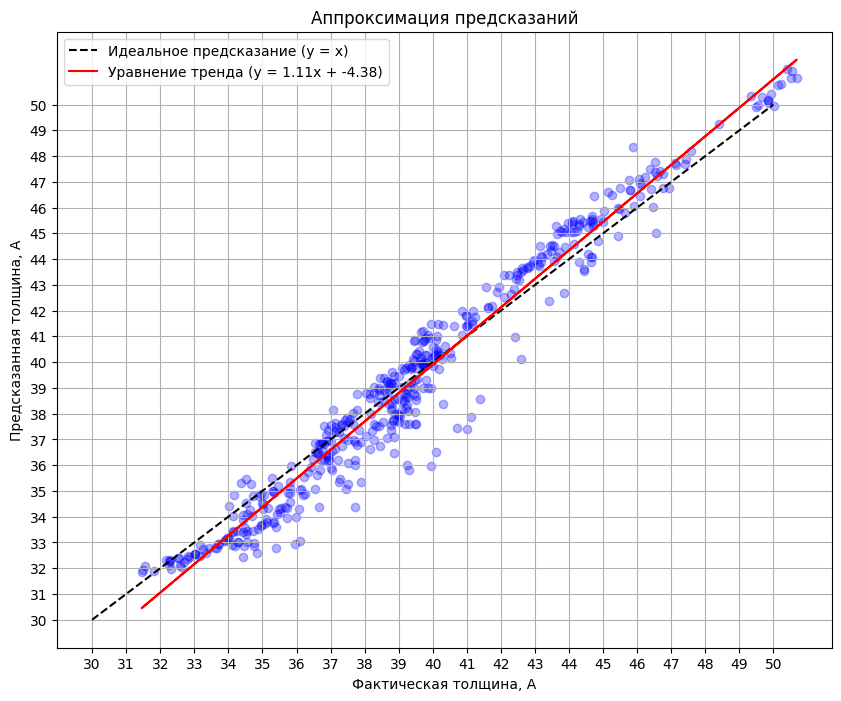

In [46]:
# Аппроксимируем тренд с помощью линейной регрессии
X_trend = y_true.reshape(-1, 1)

lr = LinearRegression()
lr.fit(X_trend, y_pred)

y_trend = lr.predict(X_trend)

# Выделим коэффициенты тренда
k = lr.coef_[0]
b = lr.intercept_

plt.figure(figsize=(10, 8))

plt.scatter(y_true, y_pred, alpha=0.3, color='blue')

# Линия идеального предсказания
x = np.linspace(30, 50, 40)
y = x
plt.plot(x, y, 'k--', label='Идеальное предсказание (y = x)')

# Аппроксимированный тренд
plt.plot(y_true, y_trend, 'r-', label=f'Уравнение тренда (y = {k:.2f}x + {b:.2f})')

plt.xlabel('Фактическая толщина, A')
plt.ylabel('Предсказанная толщина, A')
plt.xticks(np.arange(30, 51, 1))
plt.yticks(np.arange(30, 51, 1))
plt.title('Аппроксимация предсказаний')
plt.legend()
plt.grid(True)

Модель немного завышает предсказания для относительно больших толщин липидных мембран и занижает предсказания для относительно малых толщин.

Визуализируем абсолютные ошибки предсказаний для всех объектов тестовой выборки для каждой толщины мембраны и построим гистограмму распределения ошибок.

/tmp/ipython-input-2320833784.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


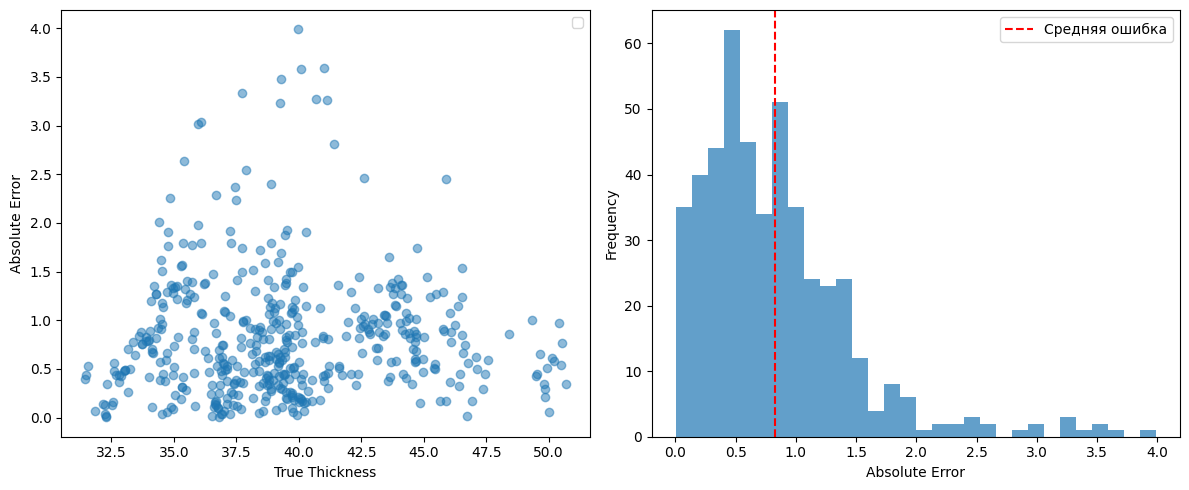

In [47]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(results['true_thickness'], results['absolute_error'], alpha=0.5)

plt.xlabel('True Thickness')
plt.ylabel('Absolute Error')
plt.legend()

plt.subplot(1, 2, 2)

plt.hist(results['absolute_error'], bins=30, alpha=0.7)
plt.axvline(results['absolute_error'].mean(), color='red', linestyle='--', label='Средняя ошибка')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

Можно заметить, что распределение ошибок имеет длинный правый хвост, присутствуют редкие ошибки на уровне 3 - 4 ангстремов. Такие ошибки все-таки весьма существенны, учитывая характерные толщины мембран в 30 - 50 А (т.е. относительная ошибка достигает уровня около 10%). Тем не менее, для значительной части данных абсолютные ошибки менее 1.5 ангстрем, что в целом является приемлемой точностью. Наибольшие ошибки присущи толщинам в диапазоне 35 - 45 А, что может быть объяснимо тем, что в этом интервале находится больше данных.

In [48]:
# Сохраним модель и scaler
model.save('thickness_model.keras')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

**Вывод:**  
Произведено тестирование модели на выборке, состоящей из реальных данных малоуглового рассеяния нейтронов на липидных везикулах. Значение метрики MAE на тестовой выборке составило около 0.82 А, а r2 - 0.93, что является приемлемым результатом по предсказанию толщины липидных мембран на основе малоугловых кривых рассеяния. Модель немного завышает предсказания для относительно больших толщин липидных мембран и занижает предсказания для относительно малых толщин. Несмотря на то что присутствуют ошибки на уровне 3 - 4 ангстремов, которые являются весьма существенными, тем не менее, для значительной части данных абсолютные ошибки менее 1.5 ангстрем, что в целом является приемлемой точностью.

## Общий вывод
В настоящем разделе работы проанализированы синтетические сгенерированные данные малоуглового рассеяния нейтронов на липидных везикулах и реальные данные со спектрометра ЮМО. Показано, что кривые рассеяния были сгенерированы успешно, поскольку отсутствуют аномальные значения интенсивностей и значений переданного импульса q. Отфильтрованы кривые с неудовлетворительными результатами фитирования (относительно высоким значением хи-квадрат), что является необходимым этапом подготовки данных. Установлено, что синтетические данные кривых рассеяния покрыли почти весь интервал интенсивностей I тестовой выборки реальных кривых рассеяния практически на всем диапазоне по q, хотя вариативность при относительно высоких q в тестовых данных все-таки несколько выше.

Синтетические кривые рассеяния служили в качестве тренировочной и валидационной выборок, а реальные кривые - в качестве тестовой выборки для полносвязной нейронной сети, состоящей из 4-х скрытых слоев (71617 параметров). Нейронная сеть была успешно обучена на 100 эпохах. Метрика MAE на тестовой выборке равна около 0.82 А (на валидационной MAE около 0.3 А), а r2 - 0.93, что является приемлемым результатом по предсказанию толщины липидных мембран в везикулах на основе малоугловых кривых рассеяния нейтронов спектрометра ЮМО.

Дальнейшие шаги по улучшению модели могут включать в себя увеличение количества сгенерированных синтетических кривых, на которых обучалась модель, расширение диапазона толщин мембран, более качественная аугментация кривых и учет дополнительных инструментальных особенностей установки ЮМО, накопление большего количества реальных данных на установке ЮМО для использования их в качестве валидационной выборки, а также улучшение архитектуры модели.